In [375]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torchmin import minimize
from scipy.linalg import cholesky, solve_triangular, det
import scipy.stats as stats
from scipy.stats.distributions import chi2

In [418]:
# Parameters
num_patients = 200
mean_test_score = 40 # fixed intercept
mean_age = 40
age_std = 10
patient_affected_prob = 0.6 
male_prob = 0.5 # gender probability
noise_var = 0.1  
var_time_effect = 1.0
var_intercept = 1.0  # intercept steht für Ausgangsniveau
var_slope = 0.1 # slope steht für effektstärke / steigung

b_1 = -4.0 # effect of affected family
b_2 = 0.0 # effect of sex 
b_3 = 0.2 # effect of age

def simulate_data(num_patients):
    # Generate data
    data = []
    data_we = []

    # simuliere einen Datensatz eines Krankheitsverlauf mit infizierten und gesunden Patienten def simulate_dataset(num_patients):
    for patient_id in range(num_patients):
        # Randomly determine if family is affected
        patient_affected = np.random.choice([0, 1], p=[1-patient_affected_prob, patient_affected_prob])
    
        # Randomly determine sex
        sex = np.random.choice([0, 1], p=[1-male_prob, male_prob])

        # Randomly determine age
        age = np.random.normal(mean_age,age_std)
    
        # Randomly generate time points
        num_time_points = np.random.choice([4,5,6,7,8,9,10])
        time_points = np.sort(np.random.uniform(0, 10, num_time_points))
    
        # Generate random effects
        random_intercept = np.random.normal(0.0,np.sqrt(var_intercept))
        random_slope = np.random.normal(0.0, var_slope)
        time_effects = np.random.normal(0.0, np.sqrt(var_time_effect))
    
        for j,t in enumerate(time_points):
            # Generate noise
            noise = np.random.normal(0.0, np.sqrt(noise_var))
        
            # Simulate test score
            test_score = mean_test_score + random_intercept + b_1 * patient_affected + b_2 * sex + b_3 * age +  time_effects * t + random_slope + noise
            score_we = mean_test_score + random_intercept + b_1 * patient_affected + b_3 * age + time_effects * t + random_slope + noise

            data_we.append([patient_id, t, patient_affected, age, score_we])
            data.append([patient_id, t, patient_affected, sex, age, test_score])
    return [data, data_we]

data = simulate_data(num_patients)
df_base = pd.DataFrame(data[0], columns=['patient_id', 'years_after_treatment', 'patient_affected', 'sex', 'age', 'test_score'])
# df_we = pd.DataFrame(data[1], columns=['patient_id', 'years_after_treatment', 'patient_affected', 'age', 'test_score'])
# df_unknown_values = pd.DataFrame(ground_truth, columns=['patient_id', 'years_after_treatment', 'random_intercept', 'random_time_effect', 'noise'])

# print(df[:5])

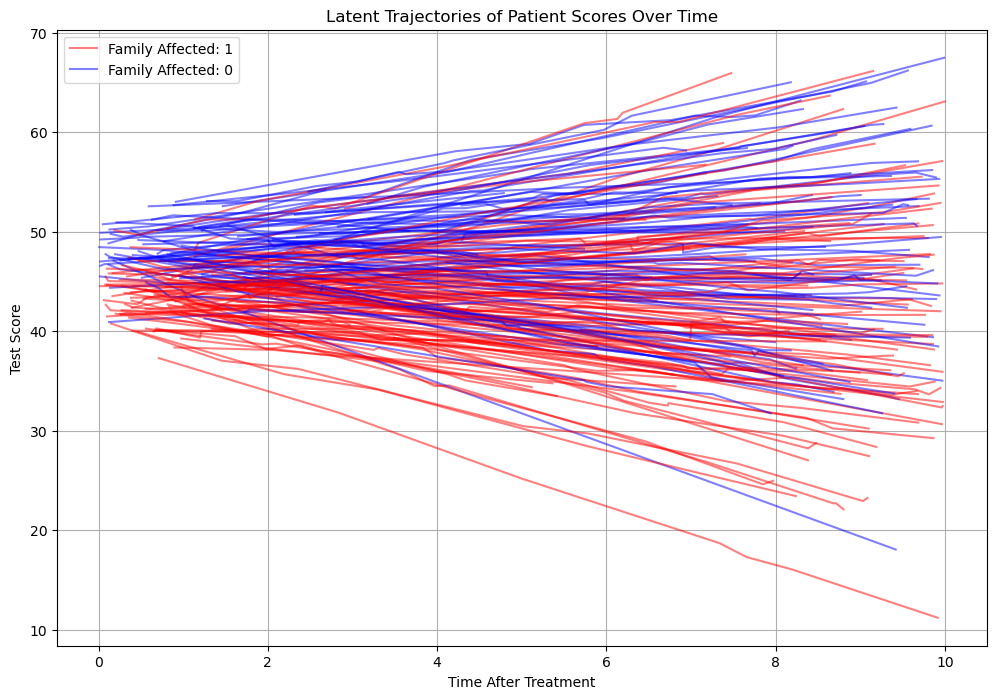

In [374]:
# plot the dataset

color_effect = 'patient_affected' #sex 

# Assuming you have your data in a DataFrame named 'df'
marker_map = {0: 'blue', 1: 'red'} 

plt.figure(figsize=(12, 8))
# Create a set to track which labels have already been added to the legend
added_labels = set()

for patient_id in df_base['patient_id'].unique():
    patient_data = df_base[df_base['patient_id'] == patient_id]
    
    label = patient_data[color_effect].iloc[0]
    color = marker_map[label]

    # Check if the label has been added to the legend
    if label not in added_labels:
        plt.plot(patient_data['years_after_treatment'], patient_data['test_score'],
                 alpha=0.5, color=color, label=f'Family Affected: {label}')
        added_labels.add(label)
    else:
        plt.plot(patient_data['years_after_treatment'], patient_data['test_score'],
                 alpha=0.5, color=color)

plt.title('Latent Trajectories of Patient Scores Over Time')
plt.xlabel('Time After Treatment')
plt.ylabel('Test Score')
plt.grid(True)
plt.legend()
plt.show()

In [419]:
# return index of first occur of 'pat' in collumn patient_id
def get_ind(pat, df):
    return np.where(df['patient_id'] == pat)[0]

# returns a block diagonal matrix of a list of matrices
def block_diag_list(arrs_list):
    shape = torch.sum(torch.tensor([a.shape for a in arrs_list], dtype=torch.int32), dim=0)
    dtype = arrs_list[0].dtype
    device = arrs_list[0].device

    out = torch.zeros(*shape.tolist(), dtype=dtype, device=device)

    r, c = 0, 0
    for a in arrs_list:
        rows, cols = a.shape
        out[r:r + rows, c:c + cols] = a
        r += rows
        c += cols
    return out


# Random effects design matrix (Datenmatrix) for each patient
def calculate_Zlist(df, random_effects_keys):
    Z_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), random_effects_keys]))
                        ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return Z_list

# Fixed effects design matrix (Datenmatrix) for each patient
def calculate_Xlist(df, fixed_effects_keys):
    X_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), fixed_effects_keys]))
                         ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return X_list

In [420]:
def likelihood_ratio(Lmin, Lmax, diff):
    L_diff = 2 * (Lmax - Lmin)
    return stats.chi2.sf(L_diff.detach().numpy(), diff)

In [421]:
#keys for random and fixed effects in the matrix
fixed_effects_keys = ['patient_affected', 'sex', 'age']
random_effects_keys = ['years_after_treatment']

fixed_effects_keys_we = ['patient_affected', 'age']
random_effects_keys_we = ['years_after_treatment']

D_param = torch.randn(len(random_effects_keys) + 1, requires_grad=True)

def calculate_likelihood_df(df, fixed_effects, random_effects):
    n_fixed_eff = len(fixed_effects) + 1
    n_rand_eff = len(random_effects) + 1
    N = len(df)

    # Fixed effects design matrix (Datenmatrix) for each patient
    X_list = calculate_Xlist(df, fixed_effects)
    # Random effects design matrix (Datenmatrix) for each patient
    Z_list = calculate_Zlist(df, random_effects)
    # Response variable: Test scores
    y = torch.from_numpy(np.array(df['test_score'])).to(torch.float32)

    # Defining list of X tilde (eq. 2.7 p. 63)
    X_tilde_list = [torch.cat((X_i, torch.zeros((n_rand_eff, n_fixed_eff)))) for X_i in X_list]
    # Augmented response vector y_e (eq. 2.11 p. 65)
    y_e = torch.cat([torch.cat((y[get_ind(pat, df)], torch.zeros(n_rand_eff))).unsqueeze(-1) for pat in df['patient_id'].unique()])

    # Ensure that the diagonal covariance matrix has only positive values
    Delta =  torch.diag(torch.nn.functional.softplus(D_param))
    det_Delta = torch.det(Delta)  

    # Defining list of Z tilde (eq. 2.7 p. 63)
    Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list]
    # Matrix X_e (eq. 2.11 p. 65)
    X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list)), -1)

    Q, R = torch.linalg.qr(X_e)
    # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
    pred = torch.linalg.solve(R, Q.T @ y_e)  # R @ pred = Q^T @ y_e
    # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
    pred_sigma = torch.sum((y_e - X_e @ pred) ** 2) / N

    # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
    likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
    likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
    return - likelihood

#likelihood = calculate_likelihood_df(df, fixed_effects_keys, random_effects_keys)
#likelihood_we = calculate_likelihood_df(df_we, fixed_effects_keys_we, random_effects_keys_we)

#result = likelihood_ratio(likelihood_we,likelihood, 1)
#print(result)

In [ ]:
# Alternative: Minimize the log-likelihood with 1st order optimizer
optimizer = Adam([D_param], lr=0.1)
for i in range(100):
    optimizer.zero_grad()
    likelihood = calculate_likelihood_df(df_base, fixed_effects_keys, random_effects_keys)
    likelihood.backward() 
    optimizer.step()  


In [422]:
def run_simulation(num_simulations):
    lrt_results = []
    optimizer = Adam([D_param], lr=0.1)
    optimizer_we = Adam([D_param], lr=0.1) 
    for i in range(200):
        df = pd.DataFrame(simulate_data(200)[0], columns=['patient_id', 'years_after_treatment', 'patient_affected', 'sex', 'age', 'test_score'])
        df_we = pd.DataFrame(simulate_data(200)[1], columns=['patient_id', 'years_after_treatment', 'patient_affected', 'age', 'test_score'])
        for _ in range(100):
            optimizer.zero_grad()
            likelihood = calculate_likelihood_df(df, fixed_effects_keys, random_effects_keys)
            likelihood.backward()
            optimizer.step()
            optimizer_we.zero_grad()
            likelihood_we = calculate_likelihood_df(df_we, fixed_effects_keys_we, random_effects_keys_we)
            likelihood_we.backward()
            optimizer_we.step()  
        L1 = calculate_likelihood_df(df,fixed_effects_keys, random_effects_keys)
        L2 = calculate_likelihood_df(df_we,fixed_effects_keys_we, random_effects_keys_we)
        lrt_results.append(likelihood_ratio(L2,L1,1))
    return lrt_results

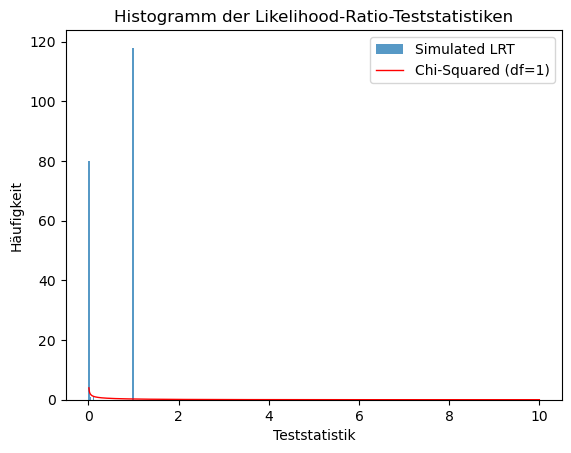

In [423]:
num_simulations = 100
lrt_results = run_simulation(num_simulations)
# Histogramm der Teststatistiken erstellen
plt.hist(lrt_results, bins=30, alpha=0.75, label='Simulated LRT')

# Chi-Quadrat-Verteilung mit einem Freiheitsgrad plotten (für Vergleich)
x = np.linspace(0, 10, 1000)
plt.plot(x, chi2.pdf(x, df=1), 'r-', lw=1, label='Chi-Squared (df=1)')

# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Histogramm anzeigen
plt.show()